In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path="/content/drive/MyDrive/Deep Learning/"

In [4]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  a, b, c, d = 0, 0, 0, 0
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      a=x; b=y; c=w; d=h;
  # save image
  cv2.imwrite(filename, img)

  return filename, a, b, c, d

<IPython.core.display.Javascript object>

(480, 640)
212 168 163 163
Saved to photo.jpg


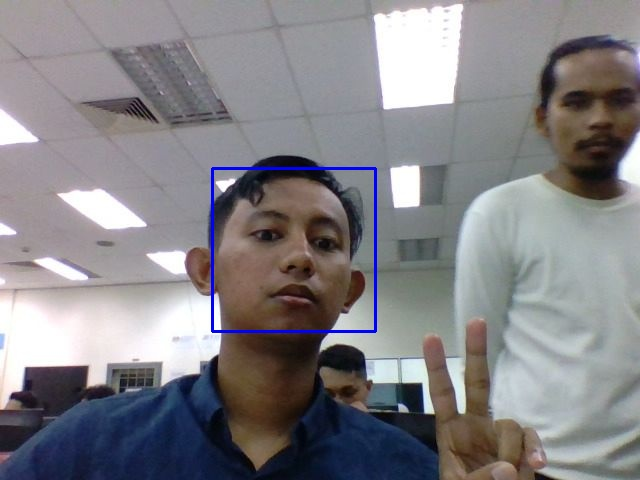

In [8]:
try:
  filename = take_photo('photo.jpg')
  x = filename[1]
  y = filename[2]
  w = filename[3]
  z = filename[4]
  print(x,y,w,z)
  print('Saved to {}'.format(filename[0]))
  
  # Show the image which was just taken.
  display(Image(filename[0]))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [9]:
img = cv2.imread("photo.jpg")

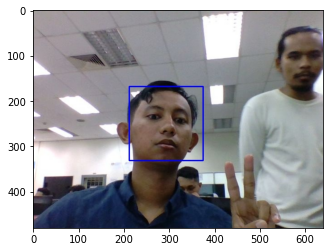

In [10]:
# Notice the COLOR_BGR2RGB which means that the color is
# converted from BGR to RGB
color_coverted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
# using pillow
# pil_image = Image.fromarray(color_coverted)
# pil_image.show()

# using matplotlib
# plt.figure(figsize=(10,10))
plt.imshow(color_coverted)
plt.show()

In [11]:
img.shape


(480, 640, 3)

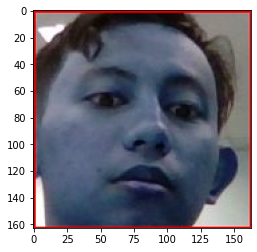

In [12]:
cropped_region = img[y:y+z, x:x+w]
color_coverted = cropped_region
plt.imshow(color_coverted)
plt.show()

In [13]:
print (x, y, w, z)

212 168 163 163


In [14]:
def displayImage(image):
    if len(image.shape)==3:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(color_coverted)
        plt.show()
        
    else:
        plt.imshow(image, cmap="gray")
        plt.show()


In [15]:
kernel = np.ones((3,3), np.float32)/14

In [18]:
kernel

array([[ 0, -1,  0],
       [-1,  5, -1],
       [ 0, -1,  0]])

In [17]:
# lets try to sharpen the image

kernel = np.array([[0,-1,0],
                  [-1,5,-1],
                  [0,-1,0]])

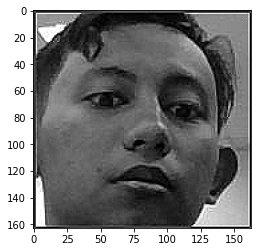

In [19]:
#img = cv2.imread(path+"ronaldo.jpeg")
grayImage = cv2.cvtColor(cropped_region,cv2.COLOR_RGB2GRAY)
convolvedImg = cv2.filter2D(grayImage, -1,kernel)

# pil_img = Image.fromarray(convolvedImg)
# pil_img.show()

displayImage(convolvedImg)

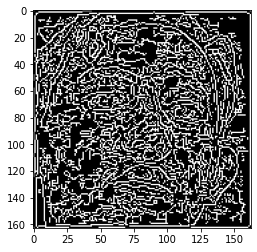

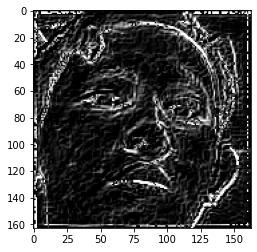

In [20]:
# canny
imgCanny = cv2.Canny(convolvedImg,20,70)

# sobel
sobelx = cv2.Sobel(convolvedImg, cv2.CV_8U,1,0,ksize=3)
sobely = cv2.Sobel(convolvedImg, cv2.CV_8U,0,1,ksize=3)
imgSobel = sobelx + sobely

displayImage(imgCanny)
displayImage(imgSobel)

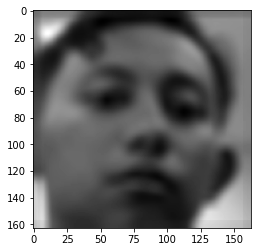

In [21]:
imgBlur = cv2.GaussianBlur(grayImage,(11,11),5)
# median = cv2.medianBlur(img,5)
# blur = cv2.bilateralFilter(img,9,75,75)

# Displaying the converted image
# pil_img = Image.fromarray(imgBlur)
# pil_img.show()

displayImage(imgBlur)

Blur Edge Detection:


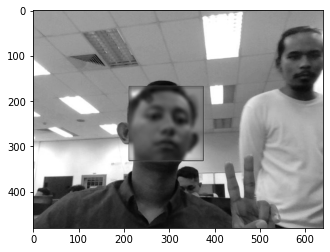

True

In [29]:
imgCanny = cv2.Canny(convolvedImg,20,70)
original = cv2.imread("photo.jpg")
original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
original[y:y+z, x:x+w] = imgBlur
print("Blur Edge Detection:")
displayImage(original)
cv2.imwrite("blur.jpg", original)